In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
train = pd.read_csv('train.csv')
X_train = train.drop('price', axis=1)
y_train = train['price']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=47)

2024-09-23 12:07:40.317899: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 12:07:40.343596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 12:07:40.361740: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 12:07:40.367089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 12:07:40.384493: I tensorflow/core/platform/cpu_feature_guar

<Axes: xlabel='price', ylabel='Count'>

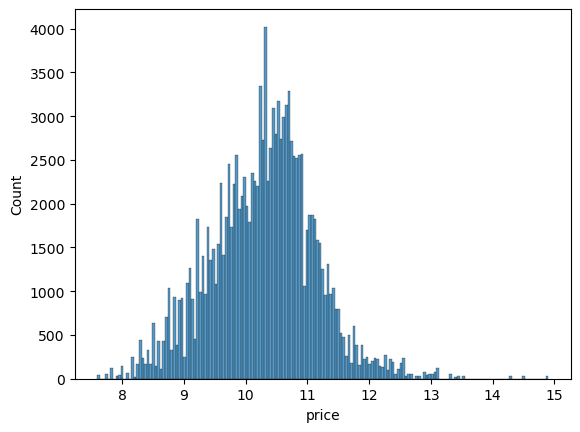

In [2]:
sns.histplot(np.log(y_train))

### Nulls

In [3]:
for col in X_train.columns:
    print(f'{col} has nulls? {X_train[col].isna().any()}')

id has nulls? False
brand has nulls? False
model has nulls? False
model_year has nulls? False
milage has nulls? False
fuel_type has nulls? True
engine has nulls? False
transmission has nulls? False
ext_col has nulls? False
int_col has nulls? False
accident has nulls? True
clean_title has nulls? True


In [4]:
X_train[X_train['fuel_type'].isna()]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
32460,32460,Ford,Mustang Mach-E California Route 1,2023,16800,NaN,Electric Motor Electric Fuel System,1-Speed A/T,Black,Black,None reported,Yes
81909,81909,Audi,Q4 e-tron 50 Premium Plus,2017,148740,NaN,295.0HP Electric Motor Electric Fuel System,A/T,Gray,Black,None reported,Yes
42973,42973,Tesla,Model Y Long Range,2021,74122,NaN,425.0HP Electric Motor Electric Fuel System,A/T,Black,White,None reported,Yes
51931,51931,Kia,Niro EV EX,2022,2537,NaN,1.6L I4 16V GDI DOHC Turbo,Automatic,Glacial White Pearl,Black,None reported,Yes
22720,22720,Tesla,Model X Long Range Plus,2021,52000,NaN,534.0HP Electric Motor Electric Fuel System,A/T,Gray,Gray,None reported,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
153989,153989,Tesla,Model 3 Standard Range Plus,2018,13079,NaN,271.0HP Electric Motor Electric Fuel System,1-Speed A/T,White,Black,None reported,Yes
83837,83837,Tesla,Model Y Long Range,2022,9142,NaN,425.0HP Electric Motor Electric Fuel System,1-Speed A/T,Blue,Gray,None reported,Yes
28724,28724,Audi,e-tron Prestige,2019,3552,NaN,355.0HP Electric Motor Electric Fuel System,1-Speed A/T,Blue,Black,None reported,Yes
82371,82371,Porsche,Taycan Base,2021,6900,NaN,375.0HP Electric Motor Electric Fuel System,2-Speed A/T,Gray,Beige,None reported,Yes


In [5]:
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('Dual'), 'Hybrid', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('Hybrid'), 'Hybrid', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('Electric'), 'Electric', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('Battery'), 'Electric', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('Gasoline'), 'Gasoline', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('Diesel'), 'Diesel', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('kW'), 'Electric', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna() & X_train['engine'].str.contains('AH'), 'Electric', X_train['fuel_type'])
X_train['fuel_type'] = np.where(X_train['fuel_type'].isna(), 'Gasoline', X_train['fuel_type'])

In [6]:
X_train[X_train['fuel_type'].isna()]['engine'].value_counts()

Series([], Name: count, dtype: int64)

In [7]:
X_train['fuel_type'].value_counts()

fuel_type
Gasoline          116218
Hybrid              4886
E85 Flex Fuel       3787
Electric            3427
Diesel              2729
–                    560
Plug-In Hybrid       354
not supported         12
Name: count, dtype: int64

In [8]:
X_train['accident'].value_counts()

accident
None reported                             101066
At least 1 accident or damage reported     29172
Name: count, dtype: int64

In [9]:
X_train['accident'] = np.where(X_train['accident'].isna(), 'None reported', X_train['accident'])

In [10]:
X_train['clean_title'].value_counts()

clean_title
Yes    116979
Name: count, dtype: int64

In [11]:
X_train['clean_title'] = np.where(X_train['clean_title'].isna(), 'No', X_train['clean_title'])
X_train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
76906,76906,Audi,S4 3.0T Premium Plus,2022,14000,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,Red,None reported,Yes
37131,37131,Acura,TLX V6 Advance,2014,51850,Gasoline,290.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
158440,158440,Audi,S5 3.0T Prestige,2018,38718,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
131752,131752,Acura,MDX Sport,2003,167000,Gasoline,300.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes
62865,62865,Toyota,Land Cruiser Base,2020,29500,Gasoline,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Gold,Black,None reported,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
98046,98046,Lexus,GX 470 Base,2010,116600,Gasoline,263.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,A/T,White,Gray,At least 1 accident or damage reported,Yes
11795,11795,Tesla,Model X 75D,2017,61000,Electric,518.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes
152789,152789,Chevrolet,Camaro 2SS,2016,49700,Gasoline,455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Gray,At least 1 accident or damage reported,Yes
91971,91971,Jeep,Cherokee Sport,2022,13692,Gasoline,3.6L V6 24V MPFI DOHC,8-Speed Automatic,Sting Gray Clearcoat,Black,None reported,Yes


### Outliers

In [12]:
X_train_temp = X_train.copy()
X_train_temp['price'] = y_train
X_train_temp.columns
X_train_temp.groupby('int_col')['price'].mean().sort_values()
X_train_temp[X_train_temp['price'] >= 1599000]['model']
# Para cada outlier buscar el modelo y asignar precio promedio
"""
for model in X_train_temp['model'].values:
    zscorelimit = 2.5
    temp = X_train_temp[X_train_temp['model'] == model]
    tempouts = temp[np.abs(stats.zscore(temp['price'])) > zscorelimit]
    tempnormals = temp[np.abs(stats.zscore(temp['price'])) <= zscorelimit]

    print(f'{tempouts["price"].max()} now is {tempnormals["price"].mean()} for {tempouts["id"].nunique()}')

    mask = X_train_temp['id'].isin(tempouts['id'])
    X_train_temp.loc[mask, 'price'] = tempnormals['price'].mean()


X_train_temp.sort_values(by='price', ascending=False)
X_train_temp[X_train_temp['model'] == 'Martin DB7 Vantage Volante'].sort_values(by='price', ascending=False)	
"""

'\nfor model in X_train_temp[\'model\'].values:\n    zscorelimit = 2.5\n    temp = X_train_temp[X_train_temp[\'model\'] == model]\n    tempouts = temp[np.abs(stats.zscore(temp[\'price\'])) > zscorelimit]\n    tempnormals = temp[np.abs(stats.zscore(temp[\'price\'])) <= zscorelimit]\n\n    print(f\'{tempouts["price"].max()} now is {tempnormals["price"].mean()} for {tempouts["id"].nunique()}\')\n\n    mask = X_train_temp[\'id\'].isin(tempouts[\'id\'])\n    X_train_temp.loc[mask, \'price\'] = tempnormals[\'price\'].mean()\n\n\nX_train_temp.sort_values(by=\'price\', ascending=False)\nX_train_temp[X_train_temp[\'model\'] == \'Martin DB7 Vantage Volante\'].sort_values(by=\'price\', ascending=False)\t\n'

In [13]:
X_val_temp = X_val.copy()
X_val_temp['price'] = y_val
X_val_temp.columns
X_val_temp.groupby('int_col')['price'].mean().sort_values()
X_val_temp[X_val_temp['price'] >= 1599000]['model']
# Para cada outlier buscar el modelo y asignar precio promedio
"""
for model in X_val_temp['model'].values:
    zscorelimit = 2.5
    temp = X_val_temp[X_val_temp['model'] == model]
    tempouts = temp[np.abs(stats.zscore(temp['price'])) > zscorelimit]
    tempnormals = temp[np.abs(stats.zscore(temp['price'])) <= zscorelimit]

    print(f'{tempouts["price"].max()} now is {tempnormals["price"].mean()} for {tempouts["id"].nunique()}')

    mask = X_val_temp['id'].isin(tempouts['id'])
    X_val_temp.loc[mask, 'price'] = tempnormals['price'].mean()


X_val_temp.sort_values(by='price', ascending=False)
X_val_temp[X_val_temp['model'] == 'Martin DB7 Vantage Volante'].sort_values(by='price', ascending=False)
"""

'\nfor model in X_val_temp[\'model\'].values:\n    zscorelimit = 2.5\n    temp = X_val_temp[X_val_temp[\'model\'] == model]\n    tempouts = temp[np.abs(stats.zscore(temp[\'price\'])) > zscorelimit]\n    tempnormals = temp[np.abs(stats.zscore(temp[\'price\'])) <= zscorelimit]\n\n    print(f\'{tempouts["price"].max()} now is {tempnormals["price"].mean()} for {tempouts["id"].nunique()}\')\n\n    mask = X_val_temp[\'id\'].isin(tempouts[\'id\'])\n    X_val_temp.loc[mask, \'price\'] = tempnormals[\'price\'].mean()\n\n\nX_val_temp.sort_values(by=\'price\', ascending=False)\nX_val_temp[X_val_temp[\'model\'] == \'Martin DB7 Vantage Volante\'].sort_values(by=\'price\', ascending=False)\n'

### Data Grouping

#### Brand

In [14]:
X_train_temp['brand'].value_counts()

brand
Ford             16267
Mercedes-Benz    13369
BMW              11946
Chevrolet        11344
Audi              7668
Porsche           7398
Land              6669
Toyota            6139
Lexus             6054
Jeep              4517
Cadillac          3231
RAM               2996
Nissan            2805
Tesla             2587
INFINITI          2318
GMC               2279
Dodge             2218
Mazda             1905
Kia               1726
Lincoln           1710
Subaru            1691
Acura             1642
Honda             1465
Hyundai           1405
Volkswagen        1248
Jaguar             920
Bentley            810
MINI               746
Genesis            687
Maserati           661
Buick              650
Lamborghini        546
Chrysler           503
Volvo              479
Alfa               455
Rivian             423
Rolls-Royce        384
Mitsubishi         380
Pontiac            371
Hummer             360
Ferrari            254
McLaren            172
Aston              165
Satur

In [15]:
X_train_temp.groupby('brand')['price'].mean().sort_values()

brand
Scion             13468.412500
Mitsubishi        14496.457895
Maybach           15500.000000
Hummer            15948.061111
MINI              17038.317694
Saturn            18302.675926
Mercury           19710.659091
Suzuki            19857.000000
Subaru            21787.576582
FIAT              23183.696970
Honda             23378.637543
Mazda             25564.891864
Pontiac           25910.673854
Volkswagen        26751.735577
Hyundai           26883.123843
Lotus             27009.068182
Acura             28141.771620
Chrysler          29116.737575
Toyota            29360.725200
Buick             29444.121538
Nissan            29507.654189
Saab              29903.578947
Lincoln           31096.004094
Dodge             31806.923805
Volvo             31990.891441
INFINITI          33961.362813
Lexus             34288.013214
Jeep              34362.752048
smart             34664.000000
Plymouth          36144.000000
Kia               37215.111819
Karma             38461.166667
GM

In [16]:
X_train_temp['brand_category'] = np.where(X_train['brand'].isin(['Bugatti', 'Lamborghini', 'McLaren', 'Bentley', 'Ferrari', 'Rolls-Royce', 'Aston', 'Rivian']), 6,
                                    np.where(X_train['brand'].isin(['Lucid', 'Porsche', 'Maserati', 'Tesla', 'Polestar', 'Land', 'Genesis']), 5,
                                             np.where(X_train['brand'].isin(['Jaguar', 'Alfa', 'Mercedes-Benz', 'RAM', 'Karma', 'BMW', 'Maybach']), 4,
                                                      np.where(X_train['brand'].isin(['FIAT', 'Cadillac', 'Saab', 'Chevrolet', 'Audi', 'GMC', 'Ford', 'Kia', 'Jeep', 'Lexus', 'Volvo', 'INFINITI', 'Dodge', 'Lincoln']), 3,
                                                               np.where(X_train['brand'].isin(['Mercury', 'Buick', 'Lotus', 'Acura', 'Toyota', 'Nissan', 'Hyundai', 'Volkswagen', 'Mazda']), 2,
                                                                        np.where(X_train['brand'].isin(['Suzuki', 'Subaru', 'Honda', 'Chrysler', 'MINI', 'Saturn', 'Scion', 'Mitsubishi']), 1, 
                                                                                 np.where(X_train['brand'].isin(['Pontiac', 'Hummer', 'smart', 'Plymouth']), 0, -1)))))))
X_train_temp.groupby('brand_category')['price'].mean().sort_values()

brand_category
0     21162.211096
1     21516.187751
2     28351.320489
3     38988.638174
4     47902.848682
5     61417.353277
6    128633.252628
Name: price, dtype: float64

#### Fuel 

In [17]:
X_train_temp.groupby('fuel_type')['price'].mean().sort_values()

fuel_type
not supported     22574.333333
E85 Flex Fuel     26790.513599
–                 35900.567857
Gasoline          43435.371035
Plug-In Hybrid    45382.703390
Diesel            47527.488091
Hybrid            54831.919566
Electric          61211.821418
Name: price, dtype: float64

#### Engine 

In [18]:
X_train_temp.groupby('engine')['price'].mean().sort_values()

engine
3.8L V6 12V MPFI OHV                                      6500.000000
115.0HP 2.0L 4 Cylinder Engine Gasoline Fuel              6754.090909
133.0HP 2.2L 4 Cylinder Engine Gasoline Fuel              7152.200000
140.0HP 2.8L V6 Cylinder Engine Gasoline Fuel             7701.300000
285.0HP 5.7L 8 Cylinder Engine Gasoline Fuel              7785.000000
                                                            ...      
420.0HP 5.9L 12 Cylinder Engine Gasoline Fuel           226895.875000
12 Cylinder Engine                                      245366.000000
552.0HP 6.0L 12 Cylinder Engine Flex Fuel Capability    256332.111111
6.8L V12 48V GDI DOHC                                   259054.090909
5.3L V8 16V MPFI OHV Flexible Fuel                      509028.666667
Name: price, Length: 1112, dtype: float64

In [19]:
for val in X_train_temp['engine'].unique():
    print(val, end=', ')

349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel, 290.0HP 3.5L V6 Cylinder Engine Gasoline Fuel, 333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel, 300.0HP 3.7L V6 Cylinder Engine Gasoline Fuel, 381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel, 306.0HP 3.5L V6 Cylinder Engine Gasoline Fuel, 255.0HP 2.0L 4 Cylinder Engine Gasoline Fuel, 320.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel, 4.0L V8 32V GDI DOHC Twin Turbo, 3.6L V6 24V MPFI DOHC Flexible Fuel, 525.0HP 5.2L 10 Cylinder Engine Gasoline Fuel, 4.7L 8 Cylinder Engine Gasoline Fuel, 147.0HP 2.0L 4 Cylinder Engine Gasoline Fuel, 204.0HP 2.5L V6 Cylinder Engine Gasoline Fuel, 247.0HP 2.0L 4 Cylinder Engine Gasoline Fuel, 265.0HP 3.0L V6 Cylinder Engine Gasoline Fuel, 420.0HP 4.0L 8 Cylinder Engine Gasoline Fuel, 2.0L I4 16V GDI DOHC Turbo, 306.0HP 3.5L V6 Cylinder Engine Gas/Electric Hybrid, 390.0HP 5.6L 8 Cylinder Engine Gasoline Fuel, 429.0HP 4.7L 8 Cylinder Engine Gasoline Fuel, 160.0HP 2.4L 4 Cylinder Engine Gasoline Fuel, 443.0HP 3.0L

#### Transmission

In [20]:
X_train_temp.groupby('transmission')['price'].mean().sort_values()

transmission
4-Speed A/T                                            16618.340922
5-Speed M/T                                            16759.806338
5-Speed A/T                                            20515.163311
CVT Transmission                                       25572.321194
6-Speed A/T                                            25657.317549
Transmission Overdrive Switch                          26193.990654
M/T                                                    28263.718599
CVT-F                                                  30504.333333
6-Speed Electronically Controlled Automatic with O     31523.444444
A/T                                                    31662.670537
6-Speed M/T                                            33702.858456
6 Speed At/Mt                                          35685.384615
6 Speed Mt                                             36577.206897
Automatic CVT                                          37773.488294
6-Speed Automatic                  

In [21]:
for val in X_train_temp['transmission'].unique():
    print(val, end=', ')

8-Speed A/T, A/T, 6-Speed A/T, 10-Speed A/T, Transmission w/Dual Shift Mode, 9-Speed Automatic, 8-Speed Automatic, 5-Speed A/T, 7-Speed A/T, Automatic CVT, CVT Transmission, 4-Speed A/T, 9-Speed A/T, 1-Speed A/T, Automatic, 6-Speed M/T, 10-Speed Automatic, 6-Speed Automatic, 6-Speed Manual, 6 Speed Mt, 6-Speed Automatic with Auto-Shift, 5-Speed M/T, 7-Speed Automatic with Auto-Shift, M/T, Variable, 6-Speed, 7-Speed M/T, 8-Speed Automatic with Auto-Shift, F, 7-Speed Automatic, 8-SPEED AT, 7-Speed Manual, Transmission Overdrive Switch, Manual, –, 5-Speed Automatic, 1-Speed Automatic, 2-Speed A/T, 8-Speed Manual, 6-Speed Electronically Controlled Automatic with O, 4-Speed Automatic, Single-Speed Fixed Gear, 2, 7-Speed, SCHEDULED FOR OR IN PRODUCTION, 7-Speed DCT Automatic, CVT-F, 10-Speed Automatic with Overdrive, 9-Speed Automatic with Auto-Shift, 8-SPEED A/T, 6 Speed At/Mt, 2-Speed Automatic, 

In [22]:
automatic_transmissions = [
    'A/T', 'Automatic', 'Transmission w/Dual Shift Mode', '4-Speed A/T', 
    '5-Speed A/T', '6-Speed A/T', '7-Speed A/T', '8-Speed A/T', '9-Speed A/T', 
    '10-Speed A/T', '2-Speed A/T', '7-Speed Automatic', '7-Speed Automatic with Auto-Shift',
    '8-Speed Automatic', '8-Speed Automatic with Auto-Shift', '9-Speed Automatic', 
    '9-Speed Automatic with Auto-Shift', '10-Speed Automatic', 
    '10-Speed Automatic with Overdrive', '4-Speed Automatic', 
    '5-Speed Automatic', '6-Speed Automatic', 
    '6-Speed Electronically Controlled Automatic with O', 
    '6-Speed Automatic with Auto-Shift', '8-SPEED A/T', '8-SPEED AT',
    '7-Speed DCT Automatic'
]

manual_transmissions = [
    'M/T', '5-Speed M/T', '6-Speed M/T', '7-Speed M/T', '6-Speed Manual', 
    '7-Speed Manual', '8-Speed Manual', '6 Speed Mt', '6 Speed At/Mt'
]

cvt_transmissions = [
    'CVT Transmission', 'Automatic CVT', 'CVT-F', 'Variable'
]

single_speed_transmissions = [
    '1-Speed A/T', '1-Speed Automatic', 'Single-Speed Fixed Gear'
]
X_train_temp['transmission_type'] = np.where(X_train['transmission'].isin(automatic_transmissions), 'Automatic',
                                        np.where(X_train['transmission'].isin(manual_transmissions), 'Manual',
                                                 np.where(X_train['transmission'].isin(cvt_transmissions), 'CVT',
                                                          np.where(X_train['transmission'].isin(single_speed_transmissions), 'Single Speed', 'Other'))))
high_quality_transmissions = [
    '7-Speed DCT Automatic', '7-Speed Automatic with Auto-Shift', 
    '8-Speed Automatic with Auto-Shift', '9-Speed Automatic with Auto-Shift', 
    '6-Speed Automatic with Auto-Shift',

    '8-Speed A/T', '8-Speed Automatic', '8-SPEED A/T', '8-SPEED AT', 
    '9-Speed A/T', '9-Speed Automatic', '10-Speed A/T', '10-Speed Automatic', 
    '10-Speed Automatic with Overdrive',

    '6-Speed M/T', '7-Speed M/T', '6-Speed Manual', '7-Speed Manual', '8-Speed Manual'
]

mid_quality_transmissions = [
    '5-Speed A/T', '6-Speed A/T', '6-Speed Automatic', 
    '6-Speed Electronically Controlled Automatic with O', 
    'Transmission w/Dual Shift Mode',

    '5-Speed M/T', '6 Speed Mt', '6 Speed At/Mt'
]

low_quality_transmissions = [
    'A/T', 'Automatic', '4-Speed A/T', '4-Speed Automatic', 
    '5-Speed Automatic',

    '1-Speed A/T', '1-Speed Automatic', 'Single-Speed Fixed Gear', 
    '2-Speed A/T', '2-Speed Automatic'
]

cvt_quality_transmissions = [
    'CVT Transmission', 'Automatic CVT', 'CVT-F', 'Variable'
]

other_quality_transmissions = [
    'Transmission Overdrive Switch', 'F', '7-Speed', 
    'SCHEDULED FOR OR IN PRODUCTION'
]
X_train_temp['transmission_quality'] = np.where(X_train['transmission'].isin(high_quality_transmissions), 4,
                                            np.where(X_train['transmission'].isin(mid_quality_transmissions), 3,
                                                     np.where(X_train['transmission'].isin(cvt_quality_transmissions), 2,
                                                              np.where(X_train['transmission'].isin(low_quality_transmissions), 0, 1))))

#### Ext_col / Int_col

In [23]:
for val in pd.DataFrame(X_train_temp.groupby('ext_col')['price'].agg(['count', 'mean']).sort_values(by='mean')).reset_index().values:
    print(val)

['Frozen White' 4 19758.75]
['Gold' 1169 21512.231822070145]
['Purple' 243 25820.172839506173]
['Crystal Black Pearl' 21 26630.095238095237]
['Mountain Air Metallic' 7 27143.428571428572]
['Beige' 768 27827.079427083332]
['Lunar Rock' 15 27933.933333333334]
['Crimson Red Tintcoat' 20 28401.25]
['Remington Red Metallic' 19 29649.052631578947]
['Snowflake White Pearl' 145 30068.406896551725]
['Sonic Silver Metallic' 42 30442.761904761905]
['Volcanic Orange' 4 30728.75]
['Red Quartz Tintcoat' 15 30803.6]
['Jet Black Mica' 82 31061.146341463416]
['Hyper Red' 49 31132.183673469386]
['Blue Reflex Mica' 24 31180.583333333332]
['Radiant Red Metallic II' 12 31212.333333333332]
['Dazzling White' 8 31407.5]
['Caspian Blue' 9 31572.222222222223]
['Nightfall Gray Metallic' 17 31600.70588235294]
['White Clearcoat' 16 31772.6875]
['Quartz White' 23 31965.521739130436]
['Silver' 11836 32344.998648191955]
['Soul Red Crystal Metallic' 145 32606.41379310345]
['Twilight Black' 32 32631.53125]
['White Plat

In [24]:
for val in pd.DataFrame(X_train_temp.groupby('int_col')['price'].agg(['count', 'mean']).sort_values(by='mean')).reset_index().values:
    print(val)

['Medium Pewter' 16 26520.25]
['Gray' 14849 28196.204794935686]
['Light Gray' 7 28615.85714285714]
['Beige' 17190 30315.519255381034]
['Medium Ash Gray' 17 30436.882352941175]
['Deep Chestnut' 17 32126.0]
['Gold' 244 32297.053278688523]
['Ash' 23 32638.652173913044]
['White / Brown' 61 32747.245901639344]
['Whisper Beige' 11 33855.36363636364]
['Black / Graphite' 15 34449.6]
['Ebony / Ebony Accents' 15 35207.6]
['Charcoal Black' 50 35977.24]
['Mountain Brown' 19 36150.0]
['Light Platinum / Jet Black' 17 36298.05882352941]
['Light Titanium' 26 37363.57692307692]
['Gideon' 31 38435.77419354839]
['Sand Beige' 13 39237.846153846156]
['Ivory / Ebony' 25 39386.36]
['Tupelo' 10 39491.4]
['Satin Black' 107 39712.588785046726]
['Charcoal' 136 39771.52205882353]
['Chateau' 13 41051.38461538462]
['Canberra Beige' 56 41195.53571428572]
['Black / Stone Grey' 16 41394.9375]
['Boulder' 15 41485.333333333336]
['Graphite' 181 42431.160220994476]
['Gray w/Blue Bolsters' 14 42661.0]
['Silver' 308 42801.6

In [25]:
X_train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
76906,76906,Audi,S4 3.0T Premium Plus,2022,14000,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,Red,None reported,Yes
37131,37131,Acura,TLX V6 Advance,2014,51850,Gasoline,290.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
158440,158440,Audi,S5 3.0T Prestige,2018,38718,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
131752,131752,Acura,MDX Sport,2003,167000,Gasoline,300.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes
62865,62865,Toyota,Land Cruiser Base,2020,29500,Gasoline,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Gold,Black,None reported,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
98046,98046,Lexus,GX 470 Base,2010,116600,Gasoline,263.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,A/T,White,Gray,At least 1 accident or damage reported,Yes
11795,11795,Tesla,Model X 75D,2017,61000,Electric,518.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes
152789,152789,Chevrolet,Camaro 2SS,2016,49700,Gasoline,455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Gray,At least 1 accident or damage reported,Yes
91971,91971,Jeep,Cherokee Sport,2022,13692,Gasoline,3.6L V6 24V MPFI DOHC,8-Speed Automatic,Sting Gray Clearcoat,Black,None reported,Yes


### Encoding

In [26]:
X_train = X_train_temp.drop(['price'], axis=1)
X_train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,brand_category,transmission_type,transmission_quality
76906,76906,Audi,S4 3.0T Premium Plus,2022,14000,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,Red,None reported,Yes,3,Automatic,4
37131,37131,Acura,TLX V6 Advance,2014,51850,Gasoline,290.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,2,Automatic,0
158440,158440,Audi,S5 3.0T Prestige,2018,38718,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,3,Automatic,0
131752,131752,Acura,MDX Sport,2003,167000,Gasoline,300.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,2,Automatic,3
62865,62865,Toyota,Land Cruiser Base,2020,29500,Gasoline,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Gold,Black,None reported,Yes,2,Automatic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98046,98046,Lexus,GX 470 Base,2010,116600,Gasoline,263.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,A/T,White,Gray,At least 1 accident or damage reported,Yes,3,Automatic,0
11795,11795,Tesla,Model X 75D,2017,61000,Electric,518.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,5,Automatic,0
152789,152789,Chevrolet,Camaro 2SS,2016,49700,Gasoline,455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Gray,At least 1 accident or damage reported,Yes,3,Automatic,3
91971,91971,Jeep,Cherokee Sport,2022,13692,Gasoline,3.6L V6 24V MPFI DOHC,8-Speed Automatic,Sting Gray Clearcoat,Black,None reported,Yes,3,Automatic,4


In [27]:
X_train = X_train.drop('id', axis=1)
X_train = X_train.reset_index(names='id')
X_train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,brand_category,transmission_type,transmission_quality
0,76906,Audi,S4 3.0T Premium Plus,2022,14000,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,Red,None reported,Yes,3,Automatic,4
1,37131,Acura,TLX V6 Advance,2014,51850,Gasoline,290.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,2,Automatic,0
2,158440,Audi,S5 3.0T Prestige,2018,38718,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,3,Automatic,0
3,131752,Acura,MDX Sport,2003,167000,Gasoline,300.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,2,Automatic,3
4,62865,Toyota,Land Cruiser Base,2020,29500,Gasoline,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,Gold,Black,None reported,Yes,2,Automatic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131968,98046,Lexus,GX 470 Base,2010,116600,Gasoline,263.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,A/T,White,Gray,At least 1 accident or damage reported,Yes,3,Automatic,0
131969,11795,Tesla,Model X 75D,2017,61000,Electric,518.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,5,Automatic,0
131970,152789,Chevrolet,Camaro 2SS,2016,49700,Gasoline,455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Gray,At least 1 accident or damage reported,Yes,3,Automatic,3
131971,91971,Jeep,Cherokee Sport,2022,13692,Gasoline,3.6L V6 24V MPFI DOHC,8-Speed Automatic,Sting Gray Clearcoat,Black,None reported,Yes,3,Automatic,4


In [28]:
ohe = OneHotEncoder(sparse_output=False, min_frequency=15, handle_unknown='infrequent_if_exist')
X_train_ohe = ohe.fit_transform(X_train.drop(['id', 'model_year', 'milage', 'brand_category', 'transmission_quality', 'engine', 'brand', 'transmission', 'model', 'ext_col', 'int_col'], axis=1))
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out())
ohe.get_feature_names_out()

array(['fuel_type_Diesel', 'fuel_type_E85 Flex Fuel',
       'fuel_type_Electric', 'fuel_type_Gasoline', 'fuel_type_Hybrid',
       'fuel_type_Plug-In Hybrid', 'fuel_type_–',
       'fuel_type_infrequent_sklearn',
       'accident_At least 1 accident or damage reported',
       'accident_None reported', 'clean_title_No', 'clean_title_Yes',
       'transmission_type_Automatic', 'transmission_type_CVT',
       'transmission_type_Manual', 'transmission_type_Other',
       'transmission_type_Single Speed'], dtype=object)

In [29]:
X_train_ohe

,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_–,fuel_type_infrequent_sklearn,accident_At least 1 accident or damage reported,accident_None reported,clean_title_No,clean_title_Yes,transmission_type_Automatic,transmission_type_CVT,transmission_type_Manual,transmission_type_Other,transmission_type_Single Speed
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131968,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
131969,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
131970,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
131971,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [30]:
X_train_ohe['id'] = X_train['id']
X_train_ohe

,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_–,fuel_type_infrequent_sklearn,accident_At least 1 accident or damage reported,accident_None reported,clean_title_No,clean_title_Yes,transmission_type_Automatic,transmission_type_CVT,transmission_type_Manual,transmission_type_Other,transmission_type_Single Speed,id
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,76906
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,37131
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,158440
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,131752
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,62865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131968,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,98046
131969,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,11795
131970,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,152789
131971,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,91971


In [31]:
X_train_sc = X_train.drop(list(ohe.feature_names_in_) + ['engine', 'brand', 'transmission', 'model', 'ext_col', 'int_col'], axis=1).drop('id', axis=1)
ss = MinMaxScaler()
ss.fit(X_train_sc)
X_train_sc = pd.DataFrame(ss.transform(X_train_sc), columns=ss.get_feature_names_out())
X_train_sc['id'] = X_train['id']
X_train_sc

,model_year,milage,brand_category,transmission_quality,id
0,0.96,0.034329,0.500000,1.00,76906
1,0.80,0.127809,0.333333,0.00,37131
2,0.88,0.095377,0.500000,0.00,158440
3,0.58,0.412201,0.333333,0.75,131752
4,0.92,0.072611,0.333333,1.00,62865
...,...,...,...,...,...
131968,0.72,0.287725,0.500000,0.00,98046
131969,0.86,0.150408,0.833333,0.00,11795
131970,0.84,0.122499,0.500000,0.75,152789
131971,0.96,0.033569,0.500000,1.00,91971


In [32]:
X_train_sc['id'] = X_train['id']
X_train = X_train_sc.merge(X_train_ohe, on='id').merge(X_train[['id', 'engine', 'brand', 'transmission', 'model', 'ext_col', 'int_col']], on='id')
X_train = X_train.drop('id', axis=1)

## Val

In [33]:
def preprocess(df, ohe, ss):
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('Dual'), 'Hybrid', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('Hybrid'), 'Hybrid', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('Electric'), 'Electric', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('Battery'), 'Electric', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('Gasoline'), 'Gasoline', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('Diesel'), 'Diesel', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('kW'), 'Electric', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna() & df['engine'].str.contains('AH'), 'Electric', df['fuel_type'])
    df['fuel_type'] = np.where(df['fuel_type'].isna(), 'Gasoline', df['fuel_type'])
    df['accident'] = np.where(df['accident'].isna(), 'None reported', df['accident'])
    df['clean_title'] = np.where(df['clean_title'].isna(), 'No', df['clean_title'])

    df['brand_category'] = np.where(df['brand'].isin(['Bugatti', 'Lamborghini', 'McLaren', 'Bentley', 'Ferrari', 'Rolls-Royce', 'Aston', 'Rivian']), 6,
                                    np.where(df['brand'].isin(['Lucid', 'Porsche', 'Maserati', 'Tesla', 'Polestar', 'Land', 'Genesis']), 5,
                                             np.where(df['brand'].isin(['Jaguar', 'Alfa', 'Mercedes-Benz', 'RAM', 'Karma', 'BMW', 'Maybach']), 4,
                                                      np.where(df['brand'].isin(['FIAT', 'Cadillac', 'Saab', 'Chevrolet', 'Audi', 'GMC', 'Ford', 'Kia', 'Jeep', 'Lexus', 'Volvo', 'INFINITI', 'Dodge', 'Lincoln']), 3,
                                                               np.where(df['brand'].isin(['Mercury', 'Buick', 'Lotus', 'Acura', 'Toyota', 'Nissan', 'Hyundai', 'Volkswagen', 'Mazda']), 2,
                                                                        np.where(df['brand'].isin(['Suzuki', 'Subaru', 'Honda', 'Chrysler', 'MINI', 'Saturn', 'Scion', 'Mitsubishi']), 1, 
                                                                                 np.where(df['brand'].isin(['Pontiac', 'Hummer', 'smart', 'Plymouth']), 0, -1)))))))

    df['transmission_type'] = np.where(df['transmission'].isin(automatic_transmissions), 'Automatic',
                                        np.where(df['transmission'].isin(manual_transmissions), 'Manual',
                                                 np.where(df['transmission'].isin(cvt_transmissions), 'CVT',
                                                          np.where(df['transmission'].isin(single_speed_transmissions), 'Single Speed', 'Other'))))
    
    df['transmission_quality'] = np.where(df['transmission'].isin(high_quality_transmissions), 4,
                                            np.where(df['transmission'].isin(mid_quality_transmissions), 3,
                                                     np.where(df['transmission'].isin(cvt_quality_transmissions), 2,
                                                              np.where(df['transmission'].isin(low_quality_transmissions), 0, 1))))

    df = df.drop('id', axis=1)
    df = df.reset_index(names='id')

    df_ohe = pd.DataFrame(ohe.transform(df.drop(['id', 'model_year', 'milage', 'brand_category', 'transmission_quality', 'engine', 'brand', 'transmission', 'model', 'ext_col', 'int_col'], axis=1)), columns=ohe.get_feature_names_out())
    df_ohe['id'] = df['id']

    df_sc = df.drop(list(ohe.feature_names_in_) + ['engine', 'brand', 'transmission', 'model', 'ext_col', 'int_col'], axis=1).drop('id', axis=1)
    df_sc = pd.DataFrame(ss.transform(df_sc), columns=ss.get_feature_names_out())
    df_sc['id'] = df['id']

    df = df_sc.merge(df_ohe, on='id').merge(df[['id', 'engine', 'brand', 'transmission', 'model', 'ext_col', 'int_col']], on='id')

    df = df.drop('id', axis=1)

    return df

In [34]:
X_val = X_val_temp.drop(['price'], axis=1)
X_val = preprocess(X_val, ohe, ss)

In [35]:
X_val

,model_year,milage,brand_category,transmission_quality,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,...,transmission_type_CVT,transmission_type_Manual,transmission_type_Other,transmission_type_Single Speed,engine,brand,transmission,model,ext_col,int_col
0,0.86,0.138074,0.833333,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,247.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Land,8-Speed A/T,Rover Range Rover Velar P250 SE R-Dynamic,Black,Black
1,0.74,0.309753,0.666667,0.25,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,500.0HP 5.0L 10 Cylinder Engine Gasoline Fuel,BMW,7-Speed A/T,M5 Base,Blue,Beige
2,0.76,0.160286,0.500000,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,Jeep,8-Speed A/T,Wrangler Unlimited Sport,White,–
3,0.88,0.054087,0.833333,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,420.0HP 3.0L Flat 6 Cylinder Engine Gasoline Fuel,Porsche,8-Speed A/T,911 Carrera S,White,Red
4,0.90,0.117286,0.500000,1.00,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,385.0HP 6.2L 8 Cylinder Engine Flex Fuel Capab...,Ford,10-Speed A/T,F-250 XLT,White,Gray
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56555,0.90,0.068906,0.500000,0.75,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,335.0HP 3.0L V6 Cylinder Engine Gasoline/Mild ...,Audi,Transmission w/Dual Shift Mode,A8 L 55,Black,Black
56556,0.96,0.039294,0.666667,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,395.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,RAM,8-Speed A/T,1500 Laramie,White,Black
56557,0.86,0.144974,0.833333,0.75,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Genesis,Transmission w/Dual Shift Mode,G90 5.0 Ultimate,White,Beige
56558,0.86,0.022255,0.500000,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5L I4 16V GDI DOHC,Chevrolet,9-Speed Automatic,Blazer 1LT,Snowflake White Pearl,Charcoal


## Model

In [36]:
X_train.shape[0]

131973

In [37]:
X_train

,model_year,milage,brand_category,transmission_quality,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,...,transmission_type_CVT,transmission_type_Manual,transmission_type_Other,transmission_type_Single Speed,engine,brand,transmission,model,ext_col,int_col
0,0.96,0.034329,0.500000,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Audi,8-Speed A/T,S4 3.0T Premium Plus,Gray,Red
1,0.80,0.127809,0.333333,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,290.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,Acura,A/T,TLX V6 Advance,Black,Black
2,0.88,0.095377,0.500000,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Audi,A/T,S5 3.0T Prestige,Black,Black
3,0.58,0.412201,0.333333,0.75,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,300.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,Acura,6-Speed A/T,MDX Sport,Black,Black
4,0.92,0.072611,0.333333,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,381.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,Toyota,10-Speed A/T,Land Cruiser Base,Gold,Black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131968,0.72,0.287725,0.500000,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,263.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,Lexus,A/T,GX 470 Base,White,Gray
131969,0.86,0.150408,0.833333,0.00,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,518.0HP Electric Motor Electric Fuel System,Tesla,A/T,Model X 75D,Black,Black
131970,0.84,0.122499,0.500000,0.75,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Chevrolet,6-Speed A/T,Camaro 2SS,White,Gray
131971,0.96,0.033569,0.500000,1.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.6L V6 24V MPFI DOHC,Jeep,8-Speed Automatic,Cherokee Sport,Sting Gray Clearcoat,Black


In [38]:
class HyperNet(kt.HyperModel):

    def __init__(self, **kwargs):
        self.ninputs = kwargs.get('ninputs')
        self.noutputs = kwargs.get('noutputs')
        self.adapter = kwargs.get('adapter')
        super().__init__()

    def create_text_embedding(self, input_name, max_tokens, output_dim):
        input_ = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name=input_name)

        vector_layer = tf.keras.layers.TextVectorization(max_tokens=max_tokens, output_sequence_length=output_dim)
        vector_layer.adapt(self.adapter[input_name])

        vectorized_input = vector_layer(input_)

        embedding_layer = tf.keras.layers.Embedding(input_dim=max_tokens, output_dim=output_dim)
        embedded_input = embedding_layer(vectorized_input)

        pool_layer = tf.keras.layers.GlobalAveragePooling1D()
        pooled_embedding = pool_layer(embedded_input)

        return input_, pooled_embedding 

    def build(self, hp):

        nlength = hp.Int('nlength', min_value=8, max_value=15, step=1)
        nwidth = hp.Int('nwidth', min_value=150, max_value=250, step=2)
        max_tokens = hp.Int('max_tokens', min_value=900, max_value=1100, step=2)
        output_dim = hp.Int('output_dim', min_value=90, max_value=130, step=2)

        engine_input_, engine_embedded = self.create_text_embedding('engine', max_tokens, output_dim)
        brand_input_, brand_embedded = self.create_text_embedding('brand', max_tokens, output_dim)
        transmission_input_, transmission_embedded = self.create_text_embedding('transmission', max_tokens, output_dim)
        model_input_, model_embedded = self.create_text_embedding('model', max_tokens, output_dim)
        ext_col_input_, ext_col_embedded = self.create_text_embedding('ext_col', max_tokens, output_dim)
        int_col_input_, int_col_embedded = self.create_text_embedding('int_col', max_tokens, output_dim)

        input_ = tf.keras.layers.Input(shape=(self.ninputs,), name='Numericals')

        concatenated = tf.keras.layers.Concatenate()

        concat_input_ = concatenated([input_, engine_embedded, brand_embedded, transmission_embedded, model_embedded, ext_col_embedded, int_col_embedded])

        for n in range(0, nlength):
            bn = tf.keras.layers.BatchNormalization()
            midlayer = tf.keras.layers.Dense(nwidth, activation='leaky_relu', kernel_initializer='he_normal')
            do = tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05))

            if n == 0:
                mid = do(midlayer(bn(concat_input_)))
            elif n != nlength-1:
                mid = do(midlayer(bn(mid)))
            else:
                mid = midlayer(bn(mid))

        lastdo = tf.keras.layers.Dropout(rate=hp.Float('lastdropout_rate', min_value=0.0, max_value=0.5, step=0.05))
        outputlayer = tf.keras.layers.Dense(self.noutputs, activation='linear')

        output = outputlayer(lastdo(mid))

        model = tf.keras.Model(inputs=[input_, engine_input_, brand_input_, transmission_input_, model_input_, ext_col_input_, int_col_input_], outputs=[output])
        opt = tf.keras.optimizers.Nadam(learning_rate=hp.Float('learning_rate', min_value=0.005, max_value=0.1, step=0.001))

        model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])

        return model

In [39]:
trials = 30

tuner = kt.BayesianOptimization(hypermodel=HyperNet(ninputs=X_train.drop(['engine', 'brand', 'transmission', 'model', 'ext_col', 'int_col'], axis=1).shape[1], noutputs=1, adapter=X_train),
                                objective='mean_squared_error',
                                max_trials=trials,
                                max_retries_per_trial=0,
                                max_consecutive_failed_trials=trials,
                                overwrite=True,
                                project_name='Car Prices',
                                seed=47)

rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.1, patience=5, min_lr=0.00001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, restore_best_weights=True)

tuner.search({'Numericals': X_train.drop(['engine', 'brand', 'transmission', 'model', 'ext_col', 'int_col'], axis=1),
              'engine': X_train['engine'],
              'brand': X_train['brand'], 
              'transmission': X_train['transmission'], 
              'model': X_train['model'],
              'ext_col': X_train['ext_col'],
              'int_col': X_train['int_col']}, (y_train), batch_size=128, validation_data=({'Numericals': X_val.drop(['engine', 'brand', 'transmission', 'model', 'ext_col', 'int_col'], axis=1),
                                                                                                'engine': X_val['engine'],
                                                                                                'brand': X_val['brand'], 
                                                                                                'transmission': X_val['transmission'], 
                                                                                                'model': X_val['model'],
                                                                                                'ext_col': X_val['ext_col'],
                                                                                                'int_col': X_val['int_col']}, (y_val)), callbacks=[es, rlr], epochs=1000)
bestmodel = tuner.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 21m 37s]
mean_squared_error: 0.2947511076927185

Best mean_squared_error So Far: 0.29110661149024963
Total elapsed time: 05h 18m 03s


/home/nicomore/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 147 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [40]:
tuner.get_best_hyperparameters()[0].values

{'nlength': 16,
 'nwidth': 300,
 'max_tokens': 900,
 'output_dim': 200,
 'dropout_rate': 0.0,
 'lastdropout_rate': 0.35000000000000003,
 'learning_rate': 0.01}

1768/1768 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step


<Axes: ylabel='Count'>

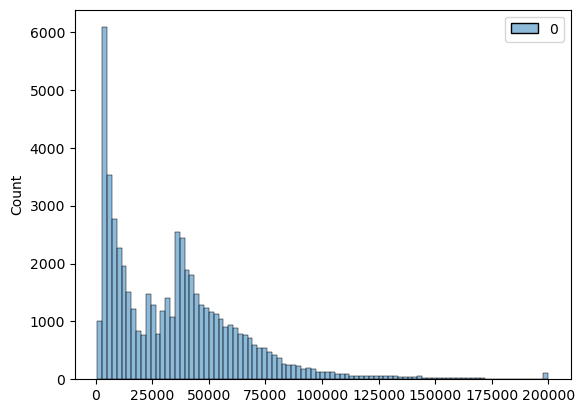

In [41]:
sns.histplot(np.clip(np.exp(bestmodel.predict({'Numericals': X_val.drop(['engine', 'brand', 'transmission', 'model', 'ext_col', 'int_col'], axis=1),
                                                                                                'engine': X_val['engine'],
                                                                                                'brand': X_val['brand'], 
                                                                                                'transmission': X_val['transmission'], 
                                                                                                'model': X_val['model'],
                                                                                                'ext_col': X_val['ext_col'],
                                                                                                'int_col': X_val['int_col']})), a_min=0, a_max=200000))

<Axes: xlabel='price', ylabel='Count'>

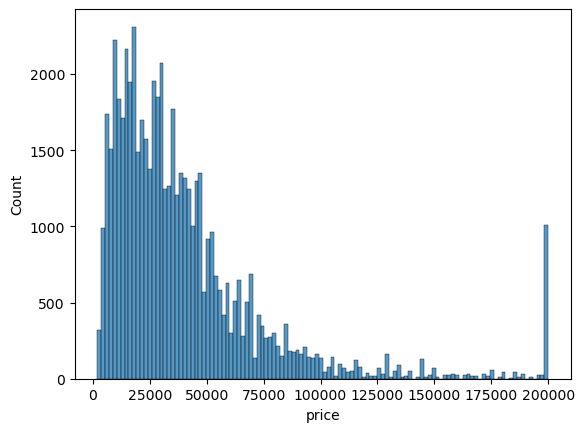

In [42]:
sns.histplot(np.clip(y_val, a_min=0, a_max=200000))

In [43]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial_id = best_trial.trial_id
metrics = tuner.oracle.get_trial(best_trial_id).metrics

In [44]:
list(best_trial.metrics.metrics.keys())

['loss',
 'mean_squared_error',
 'val_loss',
 'val_mean_squared_error',
 'learning_rate']

In [45]:
metrics_dict = {
    metric: best_trial.metrics.get_last_value(metric)
    for metric in best_trial.metrics.metrics.keys()
}
metrics_dict

{'loss': 0.29110661149024963,
 'mean_squared_error': 0.29110661149024963,
 'val_loss': 0.49043896794319153,
 'val_mean_squared_error': 0.49043896794319153,
 'learning_rate': 0.009999999776482582}

In [46]:
X_test = pd.read_csv('test.csv')
X_test_id = pd.DataFrame(X_test['id'])
X_test = preprocess(X_test, ohe, ss)

In [47]:
y_test = bestmodel.predict({'Numericals': X_test.drop(['engine', 'brand', 'transmission', 'model', 'ext_col', 'int_col'], axis=1),
                                                                                                'engine': X_test['engine'],
                                                                                                'brand': X_test['brand'], 
                                                                                                'transmission': X_test['transmission'], 
                                                                                                'model': X_test['model'],
                                                                                                'ext_col': X_test['ext_col'],
                                                                                                'int_col': X_test['int_col']})

3928/3928 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step


In [48]:
X_test_id['price'] = np.exp(y_test)

In [49]:
X_test_id.to_csv('submission.csv', index=False)